In [52]:
import json
import random

from nltk.tokenize import regexp_tokenize
from edits_generator import generate_edit_efficient

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Noise absorbing embedding

Loading training words for embeddings

In [3]:
with open('data/articles_cleaned_vocabulary.json', 'r', encoding="utf-8") as f:
    vocabulary_set = set([d[0] for d in json.load(f)])

pattern = r'([0-9]+|[а-я]+)'
with open('data/bgjargon_words.json', 'r', encoding="utf-8") as f:
    vocabulary_set.union(set([token for word in json.load(f) for token in regexp_tokenize(word, pattern)]))

vocabulary = list(vocabulary_set)
vocabulary = random.choices(vocabulary, k=100000)

Loading training comments and extracting edit alphabet

In [48]:
with open('data/blitz_comments.json', 'r', encoding="utf-8") as f:
    gold_comments = [comment_record['comment'] for comment_record in json.load(f) if 'label' in comment_record]

SOW_token = ''
EOW_token = ''
UNK_token = '�'

# alphabet = get_alphabet(gold_comments)
alphabet_for_generation = 'абвгдежзийклмнопрстуфхцчшщьъюяabcdefghijklmnopqrstuvwxyz!@#$%^&*()-_=+[]\';.,/`~"<>|1234567890'
alphabet = alphabet_for_generation
alphabet += SOW_token
alphabet += EOW_token
alphabet += UNK_token

char2ind = {}
for i, c in enumerate(alphabet):
    char2ind[c] = i

In [49]:
def generate_k_random_candidates_efficient(w, k, alphabet):
    return [generate_edit_efficient(w, alphabet) for _ in range(k)]

In [62]:
generate_k_random_candidates_efficient('ябълка', 10, alphabet_for_generation)

['яблъка',
 'ябълк',
 'яблъка',
 'ябълккка',
 'ябъка',
 'яяяябълка',
 'ябъълка',
 'ябълк]а',
 'ябълккккка',
 'ябълак']

## Encoder Decoder RNN
Trained to de-noise the candidates

In [63]:
n_alphabet = len(alphabet)
n_output = len(vocabulary)
MAX_LENGTH = 20

hidden_size = 128
batch_size = 128

In [64]:
print(n_alphabet)

96


In [65]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

    def save(self, filepath):
        torch.save(self.state_dict(), filepath)

    @classmethod
    def load(cls, filepath, input_size, hidden_size, dropout_p=0.1):
        model = cls(input_size, hidden_size, dropout_p)
        model.load_state_dict(torch.load(filepath))
        return model

In [66]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(char2ind[SOW_token])
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [67]:
def indexesFromWord(word):
    return [(char2ind[c] if c in char2ind else char2ind[UNK_token]) for c in word]

def tensorFromWord(word):
    indexes = indexesFromWord(word)
    indexes.append(char2ind[EOW_token])
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

## Training

In [68]:
pairs = [(candidate, word)
    for word in vocabulary
    for candidate in generate_k_random_candidates_efficient(word, 10, alphabet_for_generation)
    if len(candidate) < MAX_LENGTH and len(word) < MAX_LENGTH
]

In [69]:
def tensorsFromPair(pair):
    input_tensor = tensorFromWord(pair[0])
    target_tensor = tensorFromWord(pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromWord(inp)
        tgt_ids = indexesFromWord(tgt)
        inp_ids.append(char2ind[EOW_token])
        tgt_ids.append(char2ind[EOW_token])
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return train_dataloader

In [70]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [71]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100):

    print_loss_total = 0  # Reset every print_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(%d %d%%) %.4f' % (epoch, epoch / n_epochs * 100, print_loss_avg))

In [72]:
train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(n_alphabet, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, n_alphabet).to(device)

train(train_dataloader, encoder, decoder, 10, print_every=1)

(1 10%) 0.2819
(2 20%) 0.1501
(3 30%) 0.1341
(4 40%) 0.1252
(5 50%) 0.1194
(6 60%) 0.1149
(7 70%) 0.1117
(8 80%) 0.1091
(9 90%) 0.1070
(10 100%) 0.1052


In [17]:
encoder.eval()
decoder.eval()

def evaluate(word):
    with torch.no_grad():
        input_tensor = tensorFromWord(word)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_chars = []
        for idx in decoded_ids:
            c = alphabet[idx.item()]
            if c == EOW_token:
                break
            decoded_chars.append(c)
    return "".join(decoded_chars)

Saving model

In [73]:
encoder.save("data/embedding_encoder_100_000_smaller_alphabet_repeated_letters.pth")

## Loading model

In [74]:
encoder = EncoderRNN.load("data/embedding_encoder_100_000_smaller_alphabet.pth", n_alphabet, hidden_size)
encoder.to(device)
encoder.eval()

EncoderRNN(
  (embedding): Embedding(96, 128)
  (gru): GRU(128, 128, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

Getting the produced embedding from the RNN

In [75]:
def embedding(word):
    with torch.no_grad():
        input_tensor = tensorFromWord(word)
        _, encoder_hidden = encoder(input_tensor)
    return encoder_hidden

In [76]:
def euclidean_distance(tensor1, tensor2):
    return (tensor1.flatten() - tensor2.flatten()).pow(2).sum().sqrt()

def cosine_similarity(tensor1, tensor2):
    cos = nn.CosineSimilarity(dim=0)
    return cos(tensor1.flatten(), tensor2.flatten())

Comparing similarity of embeddings of words

In [77]:
print(cosine_similarity(embedding('аааббсс'), embedding('ааббсс')))
print(cosine_similarity(embedding('газчотка'), embedding('перваз')))

tensor(0.9651, device='cuda:0')
tensor(0.5395, device='cuda:0')


In [78]:
cosine_similarity(embedding('таноба'), embedding('абонат'))

tensor(0.7875, device='cuda:0')

In [79]:
cosine_similarity(embedding('момичето'), embedding('момчето'))

tensor(0.9570, device='cuda:0')

Plotting the embeddings

In [17]:
def normalize(arr):
    norm = np.linalg.norm(arr)
    return arr/norm if norm != 0 else arr

In [80]:
E = np.vstack([embedding(word).flatten().cpu().numpy() for word in vocabulary])

In [81]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

In [82]:
svd = TruncatedSVD(n_components=100, n_iter=10)
svd.fit(E)

TruncatedSVD(n_components=100, n_iter=10)

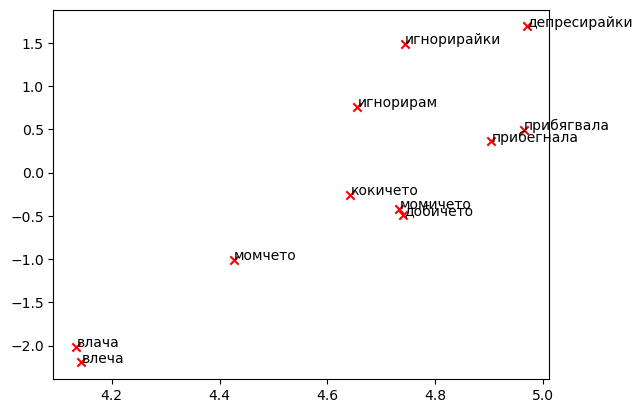

In [83]:
words = 'добичето момчето момичето кокичето игнорирам игнорирайки депресирайки прибягвала прибегнала влеча влача'.split(' ')

M = svd.transform(torch.stack([embedding(word).flatten() for word in words]).cpu())

xs = M[:,0]
ys = M[:,1]

for i in range(M.shape[0]):
    plt.scatter(xs[i],ys[i], marker='x', color= 'red')
    plt.text(xs[i].item()+0.001, ys[i].item()+0.001, words[i])
plt.show()

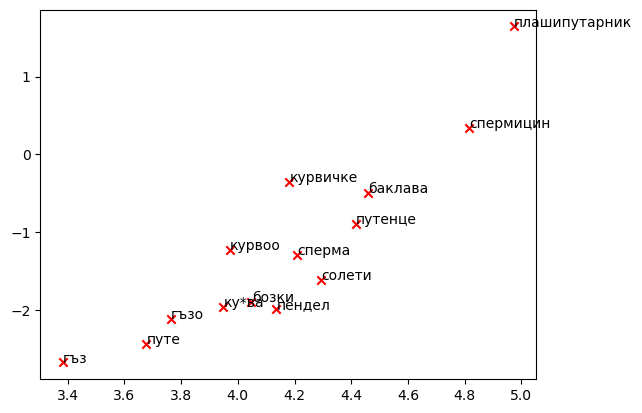

In [84]:
words = 'путе гъзо гъз путенце ку*ва курвоо курвичке солети спермицин сперма баклава бозки плашипутарник пендел'.split(' ')

M = svd.transform(torch.stack([embedding(word).flatten() for word in words]).cpu())

xs = M[:,0]
ys = M[:,1]

for i in range(M.shape[0]):
    plt.scatter(xs[i],ys[i], marker='x', color= 'red')
    plt.text(xs[i].item()+0.001, ys[i].item()+0.001, words[i])
plt.show()

Clustering some examples

In [85]:
from sklearn.cluster import KMeans

examples = 'котка котки куче кучета котките котаракът котарака котараците кучките кучка лисица лисиците лисугер'.split()
k = 4

vectors = torch.stack([embedding(word).flatten() for word in examples]).cpu().numpy()

kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(vectors)

clusters = kmeans.predict(vectors)

words_in_clusters = [np.array(examples)[np.where(clusters == i)[0]].tolist() for i in range(k)]

c:\Users\nikip\anaconda3\envs\tii\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [86]:
print(words_in_clusters)

[['лисица', 'лисиците', 'лисугер'], ['куче', 'кучета', 'кучките', 'кучка'], ['котаракът', 'котарака', 'котараците'], ['котка', 'котки', 'котките']]
